#### Explore relationships between baseline health history in MIMIC-IV and prognosis after ED attendance.

In [ ]:
%pip install tableone

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.dates import DateFormatter
from datetime import timedelta, datetime
from tqdm import tqdm
import numpy as np
from scipy import stats, special
from tableone import TableOne

import os
import json
import pprint
import missingno as msno
from statannotations.Annotator import Annotator
import warnings

pd.set_option('display.max_rows', None)

#### Test time-series measurement differences

In [2]:
ts_data = pd.read_csv('../outputs/ext_data/events_ts.csv')

In [3]:
ts_data[ts_data.label=='h'].value.describe()

count    131243.000000
mean         20.606821
std          64.014104
min           0.000000
25%           2.000000
50%           6.000000
75%          13.000000
max        1047.000000
Name: value, dtype: float64

In [3]:
ts_data.shape, ts_data.subject_id.nunique()

((6345992, 7), 36011)

In [46]:
ts_data.label.unique()

array(['alanine_aminotransferase_(alt)', 'albumin',
       'alkaline_phosphatase', 'anion_gap', 'bicarbonate',
       'bilirubin_total', 'chloride', 'creatinine', 'sodium',
       'urea_nitrogen', 'basophils', 'eosinophils', 'hematocrit',
       'hemoglobin', 'lymphocytes', 'mch', 'mchc', 'mcv', 'monocytes',
       'neutrophils', 'platelet_count', 'rdw', 'red_blood_cells',
       'white_blood_cells', 'pt', 'ptt', 'ph', 'specific_gravity',
       'calcium_total', 'magnesium', 'phosphate', 'potassium',
       'asparate_aminotransferase_(ast)', 'lactate_dehydrogenase_(ld)',
       'rdw-sd', 'rbc', 'wbc', 'absolute_lymphocyte_count',
       'absolute_basophil_count', 'absolute_eosinophil_count',
       'absolute_monocyte_count', 'absolute_neutrophil_count',
       'immature_granulocytes', 'lactate', 'base_excess',
       'calculated_total_co2', 'pco2', 'po2', 'glucose',
       'Diastolic blood pressure', 'Temperature',
       'Systolic blood pressure', 'Oxygen saturation', 'Respiratory rat

In [47]:
ts_data.columns

Index(['subject_id', 'charttime', 'itemid', 'label', 'value', 'valueuom',
       'linksto'],
      dtype='object')

<Axes: >

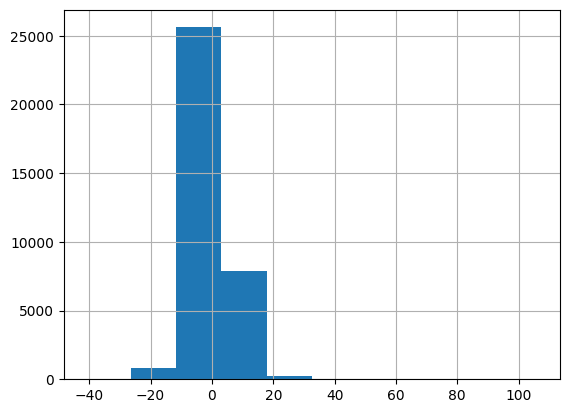

In [58]:
ts_data[ts_data.label=='base_excess']['value'].hist()

##### Load linked health data and discharge summaries

In [ ]:
demo_data = pd.read_csv('../outputs/linked_data/linked_demographics.csv')
notes_data = pd.read_csv('../outputs/linked_data/linked_notes.csv')

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
print('Discharge summary (original)')
pp.pprint(notes_data.iloc[0].target)


In [ ]:
print(demo_data.hadm_id.nunique(), demo_data.subject_id.nunique())
print(notes_data.hadm_id.nunique(), notes_data.subject_id.nunique())

##### Filter ED patients with history of previous inpatient episodes

In [ ]:
notes_grouped = notes_data.groupby('subject_id').agg({'hadm_id': 'nunique', 'input_tokens': 'sum', 'target_tokens': 'sum'}).reset_index()
notes_grouped = notes_grouped.rename(columns={'hadm_id': 'num_summaries', 'input_tokens': 'num_input_tokens', 'target_tokens': 'num_target_tokens'})
notes_grouped[['num_summaries', 'num_input_tokens', 'num_target_tokens']] = notes_grouped[['num_summaries', 'num_input_tokens', 'num_target_tokens']].astype(np.int32)

In [ ]:
ed_pts = demo_data[demo_data['subject_id'].isin(notes_data['subject_id'])]
ed_pts = ed_pts.merge(notes_grouped, on='subject_id', how='left')
print(ed_pts.hadm_id.nunique(), ed_pts.subject_id.nunique())

In [ ]:
print(ed_pts.shape)
print('Unique patients:', ed_pts.subject_id.nunique())
print('Age distribution:', ed_pts.anchor_age.describe())
print('Gender distribution:', ed_pts.gender.value_counts())
print('-------------------------------')
print('Health outcomes')
print(ed_pts.in_hosp_death.value_counts(normalize=True))
print(ed_pts.ext_stay_7.value_counts(normalize=True))
print(ed_pts.non_home_discharge.value_counts(normalize=True))
print(ed_pts.icu_admission.value_counts(normalize=True))
print('-------------------------------')
print('Comorbidity history')
print(ed_pts.is_multimorbid.value_counts(normalize=True))
print(ed_pts.is_complex_multimorbid.value_counts(normalize=True))
print(ed_pts.phys_men_multimorbidity.value_counts(normalize=True))

##### Prepare sensitive variables

In [ ]:
#### Ethnicity and marital status
ed_pts['anchor_age'] = ed_pts['anchor_age'].astype(np.int16)
ed_pts['race_group'] = np.where(ed_pts['race'].str.contains('white', case=False), 'White', 'Other')
ed_pts['race_group'] = np.where(ed_pts['race'].str.contains('black', case=False), 'Black', ed_pts['race_group'])
ed_pts['race_group'] = np.where(ed_pts['race'].str.contains('hispanic|portuguese', case=False), 'Hispanic/Latino', ed_pts['race_group'])
ed_pts['race_group'] = np.where(ed_pts['race'].str.contains('asian', case=False), 'Asian', ed_pts['race_group'])
ed_pts['marital_status'] = ed_pts['marital_status'].str.lower().str.capitalize()

In [ ]:
ed_pts['gender'].value_counts(normalize=True)

In [ ]:
ed_pts['insurance'].value_counts(normalize=True)

In [ ]:
ed_pts['marital_status'].value_counts(normalize=True)

In [ ]:
ed_pts['race_group'].value_counts(normalize=True)

In [ ]:
def prep_exploration_features(demo_path='../outputs/linked_data/linked_demographics.csv',
                              notes_path='../outputs/linked_data/linked_notes.csv'):
    demo_data = pd.read_csv(demo_path)
    notes_data = pd.read_csv(notes_path)
    print('Loaded unique patients:', demo_data.hadm_id.nunique())
    print(f'Loaded unique notes {notes_data.hadm_id.nunique()}, across {notes_data.subject_id.nunique()} patients.')
    ### Merge and aggregate notes data with demographics
    notes_grouped = notes_data.groupby('subject_id').agg({'hadm_id': 'nunique', 'input_tokens': 'sum', 'target_tokens': 'sum'}).reset_index()
    notes_grouped = notes_grouped.rename(columns={'hadm_id': 'num_summaries', 'input_tokens': 'num_input_tokens', 'target_tokens': 'num_target_tokens'})
    notes_grouped[['num_summaries', 'num_input_tokens', 'num_target_tokens']] = notes_grouped[['num_summaries', 'num_input_tokens', 'num_target_tokens']].astype(np.int32)
    ed_pts = demo_data[demo_data['subject_id'].isin(notes_data['subject_id'])]
    ed_pts = ed_pts.merge(notes_grouped, on='subject_id', how='left')
    print('Demographics summary')
    print('Unique patients:', ed_pts.subject_id.nunique())
    print('Age distribution:', ed_pts.anchor_age.describe())
    print('Gender distribution:', ed_pts.gender.value_counts())
    print('-------------------------------')
    print('Health outcomes')
    print(ed_pts.in_hosp_death.value_counts(normalize=True))
    print(ed_pts.ext_stay_7.value_counts(normalize=True))
    print(ed_pts.non_home_discharge.value_counts(normalize=True))
    print(ed_pts.icu_admission.value_counts(normalize=True))
    print('-------------------------------')
    print('Comorbidity history')
    print(ed_pts.is_multimorbid.value_counts(normalize=True))
    print(ed_pts.is_complex_multimorbid.value_counts(normalize=True))
    print(ed_pts.phys_men_multimorbidity.value_counts(normalize=True))
    #### Process Ethnicity and marital status
    ed_pts['anchor_age'] = ed_pts['anchor_age'].astype(np.int16)
    ed_pts['race_group'] = np.where(ed_pts['race'].str.contains('white|middle eastern|portuguese', case=False), 'White', 'Other')
    ed_pts['race_group'] = np.where(ed_pts['race'].str.contains('black|caribbean island', case=False), 'Black', ed_pts['race_group'])
    ed_pts['race_group'] = np.where(ed_pts['race'].str.contains('hispanic|south american', case=False), 'Hispanic/Latino', ed_pts['race_group'])
    ed_pts['race_group'] = np.where(ed_pts['race'].str.contains('asian', case=False), 'Asian', ed_pts['race_group'])
    ed_pts['marital_status'] = ed_pts['marital_status'].str.lower().str.capitalize()
    ed_pts.to_csv(demo_path, index=False)
    print('Saved processed data to:', demo_path)
    return ed_pts

In [ ]:
ed_pts = prep_exploration_features()

##### Baseline demographics in patients with ED attendance and complete discharge history

In [ ]:
def get_table_one(ed_pts, output_path, outcome, disp_dict_path='../../data/MIMIC-IV/config/feat_name_map.json',
                sensitive_attr=['Sex', 'Ethnicity', 'Marital Status', 'Insurance'],
                nn_attr = ['Age', '# historical discharge notes', '# Raw Input Tokens', '# Processed Input Tokens'],
                cat_cols=None):

    ### Load display dictionary
    with open(disp_dict_path, 'r') as f:
        disp_dict = json.load(f)
    ### Infer categorical data
    if cat_cols is None:
        cat_cols = [el for el in disp_dict.values() if el not in nn_attr]
    ed_disp = ed_pts.rename(columns=disp_dict)
    ed_disp = ed_disp[disp_dict.values()]
    ### Code categorical columns
    for col in cat_cols:
        if col not in sensitive_attr:
            ed_disp[col] = np.where(ed_disp[col]==1, 'Yes', 'No')
    ### Generate Table 1 summary with p-values for target outcome
    print(f'Generating table summary by {outcome} with prevalence {(ed_disp[outcome].value_counts(normalize=True).iloc[1]*100).round(2)}%')
    tb_one_hd = TableOne(ed_disp,
                     categorical=[col for col in cat_cols if outcome!=col],
                     nonnormal=nn_attr,
                     groupby=outcome, overall=True, pval=True, htest_name=True, tukey_test=True,
                     decimals=0, pval_adjust='bonferroni')
    tb_one_hd.to_html(output_path)
    print(f'Saved table summary grouped by {outcome} to {output_path}.')
    return tb_one_hd

In [ ]:
ihd_tb = get_table_one(ed_pts, '../outputs/exploration/t1_in_hosp_death.html', 'In-hospital Death')
ext_tb = get_table_one(ed_pts, '../outputs/exploration/t1_ext_stay.html', 'Extended Hospital Stay')
nhd_tb = get_table_one(ed_pts, '../outputs/exploration/t1_nh_discharge.html', 'Non-home Discharge')
icu_tb = get_table_one(ed_pts, '../outputs/exploration/t1_icu_admission.html', 'ICU Admission')

##### Distribution plots by sensitive groups

In [ ]:
### Define age group variable
ed_pts['age_group'] = pd.cut(ed_pts['anchor_age'],
                             bins=[18, 49, 59, 69, 79, 91],
                             labels=['<50', '50-59', '60-69', '70-79', '80+']).astype('category')

In [ ]:
def get_age_table_by_sensitive_attr(ed_pts, attr_name, outcome,
                                   value_name_col):
    ### Modify dataset into long format and parse samples by sensitive attribute
    ed_inh_long = pd.melt(ed_pts[ed_pts[outcome]==1], id_vars=[attr_name], value_vars=['age_group'], value_name=value_name_col)
    ed_inh_long = ed_inh_long.groupby([attr_name, value_name_col], observed=False).size().reset_index(name='# Patients')
    ed_y_cts = ed_inh_long.groupby(attr_name)['# Patients'].apply(lambda x: x.sum()).reset_index().rename(columns={'# Patients': 'Total'})
    ed_inh_long = ed_inh_long.merge(ed_y_cts, how='left', on=attr_name)
    ed_inh_long['Percentage'] = round(ed_inh_long['# Patients']/ed_inh_long['Total'], 4)
    return ed_inh_long

def plot_outcome_dist_by_sensitive_attr(ed_pts, output_path, attr_col,
                                    outcome_list=['in_hosp_death', 'ext_stay_7', 'non_home_discharge','icu_admission'],
                                    outcome_title=['In-hospital death', 'Extended stay (>7 days)', 'Non-home discharge', 'ICU admission'],
                                    outcome_legend={'In-hospital death': ['No', 'Yes'], 'Extended stay (>7 days)': ['No', 'Yes'],
                                                    'Non-home discharge': ['No', 'Yes'], 'ICU admission': ['No', 'Yes']},
                                    attr_xlabel='Gender', maxi=2, maxj=2,
                                    rot=0, figsize=(8,6), palette=['#1f77b4', '#ff7f0e']):
    ### Set plot config
    plt.rcParams.update({'font.size': 12, 'font.weight': 'normal', 'font.family': 'serif'})
    fig, ax = plt.subplots(2, 2, figsize=figsize, sharey=True)
    fig.suptitle(f'Health outcome distribution by {attr_xlabel}', fontsize=16)
    fig.supxlabel(attr_xlabel, fontsize=14)
    fig.supylabel('Percentage of patients with ED attendance', fontsize=14)
    outcome_idx = 0
    for i in range(maxi):
        for j in range(maxj):
            ed_gr = ed_pts.groupby([attr_col, outcome_list[outcome_idx]]).size().reset_index(name='count')
            total_counts = ed_gr.groupby(attr_col)['count'].transform('sum')
            ed_gr['percentage'] = ed_gr['count'] / total_counts * 100

            # Plot relative percentages
            sns.barplot(data=ed_gr, x=attr_col, y='percentage', hue=outcome_list[outcome_idx], ax=ax[i][j],
                        palette=palette)
            handles = [Patch(color=palette[k], label=outcome_legend[outcome_title[outcome_idx]][k]) for k in range(len(outcome_legend[outcome_title[outcome_idx]]))]
            ax[i][j].legend(handles=handles, title=outcome_title[outcome_idx])
            #ax[i][j].legend(title=outcome_title[outcome_idx], labels=outcome_legend[outcome_title[outcome_idx]])
            ax[i][j].set_xlabel('')
            ax[i][j].set_ylabel('')
            ax[i][j].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))
            if j==1:
                ax[i][j].tick_params(left=False)
            plt.sca(ax[i][j])
            plt.xticks(rotation=rot, ha='center')
            outcome_idx+=1

    plt.tight_layout()
    plt.savefig(output_path)
    print(f'Saved plot to {output_path}.')
    plt.show()

def plot_age_dist_by_sensitive_attr(ed_pts, output_path, attr_col,
                                    outcome_list=['in_hosp_death', 'ext_stay_7', 'non_home_discharge','icu_admission'],
                                    outcome_title=['In-hospital Death', 'Extended Stay (>7 days)', 'Non-home Discharge', 'ICU Admission'],
                                    attr_xlabel='gender', maxi=2, maxj=2,
                                    colors=['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000'],
                                    labels=['<50', '50-59', '60-69', '70-79', '80+'],
                                    figsize=(8,6), rot=0):
    ### Set plot config
    plt.rcParams.update({'font.size': 12, 'font.weight': 'normal', 'font.family': 'serif'})
    fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
    fig.suptitle('Age distribution by sensitive variable in patients with adverse event.', fontsize=16)
    fig.supxlabel(attr_xlabel, fontsize=14)
    fig.supylabel('Percentage of patients with ED attendance', fontsize=14)
    outcome_idx = 0
    lg_flag = False
    for i in range(maxi):
        for j in range(maxj):
            lg_flag = True if outcome_idx == 1 else False
            ed_long = get_age_table_by_sensitive_attr(ed_pts, attr_col, outcome_list[outcome_idx], 'age_'+attr_xlabel)
            ax[i][j] = pd.pivot_table(ed_long[[attr_col, 'age_'+attr_xlabel, 'Percentage']], columns='age_'+attr_xlabel,
                                      index=attr_col, sort=True, observed=False).plot(title=outcome_title[outcome_idx],
                                                                                      kind='bar', stacked=True, figsize=figsize,
                                                                      ax=ax[i][j], legend=lg_flag,
                                                                      color=colors)
            if lg_flag:
                ax[i][j].legend(title='Age Group', labels=labels, bbox_to_anchor=(1,1))
            if j==1:
                ax[i][j].tick_params(left=False)
            ax[i][j].set_xlabel('')
            ax[i][j].set_ylabel('')
            ax[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
            plt.sca(ax[i][j])
            plt.xticks(rotation=rot, ha='center')
            outcome_idx+=1

    plt.tight_layout()
    plt.savefig(output_path)
    print(f'Saved plot to {output_path}.')
    plt.show()


In [ ]:
def get_token_length_by_attribute(ed_tg, output_path,
                                    attr_list=['gender', 'insurance', 'race_group', 'marital_status'],
                                    attr_title=['Gender', 'Insurance type', 'Ethnicity', 'Marital status'],
                                    maxi=2, maxj=2,
                                    figsize=(8,6), rot=0, ylim=(0,12),
                                    gr_pairs={'gender': [('M', 'F')],
                                              'insurance': [('Medicare', 'Medicaid'), ('Medicare', 'Private'), ('Medicaid', 'Private')],
                                              'race_group': [('White', 'Black'), ('White', 'Hispanic/Latino'), ('White', 'Asian'),
                                                             ('Black', 'Hispanic/Latino'), ('Black', 'Asian'), ('Hispanic/Latino', 'Asian')],
                                              'marital_status': [('Divorced', 'Single'), ('Divorced', 'Married'), ('Divorced', 'Widowed'),
                                                                 ('Single', 'Married'), ('Single', 'Widowed'), ('Married', 'Widowed')],
                                              },
                                    suptitle='BHC token length by sensitive variable in patients with ED attendance.',
                                    outcome_mode=False):

    ### log transform target tokens
    ed_tg['num_target_tokens_lg'] = np.log1p(ed_tg['num_target_tokens'])
    ## Exclude other categories
    ed_tg = ed_tg[ed_tg['race_group']!='Other']
    ed_tg = ed_tg[ed_tg['insurance']!='Other']
    ### Set plot config
    plt.rcParams.update({'font.size': 12, 'font.weight': 'normal', 'font.family': 'serif'})
    fig, ax = plt.subplots(2, 2, figsize=figsize, sharey=True)
    fig.suptitle(suptitle, fontsize=16)
    fig.supylabel('Log-transformed token length', fontsize=14)
    attr_idx = 0
    for i in range(maxi):
        for j in range(maxj):
            ### If exploring health outcomes, relabel the categories
            if outcome_mode:
                ed_tg[attr_list[attr_idx]] = pd.Categorical(np.where(ed_tg[attr_list[attr_idx]]==1, 'Y', 'N'))
            ax[i][j] = sns.violinplot(data=ed_tg, x=attr_list[attr_idx], y='num_target_tokens_lg', ax=ax[i][j])
            ax[i][j].set_xlabel(attr_title[attr_idx])
            ax[i][j].set_ylabel('')
            if j==1:
                ax[i][j].tick_params(left=False)
            plt.sca(ax[i][j])
            plt.xticks(rotation=rot, ha='center')
            plt.ylim(ylim)
            ### Annotate significant differences
            print(f'Annotating significant differences for {attr_list[attr_idx]}')
            annot = Annotator(ax[i][j], data=ed_tg, x=attr_list[attr_idx], y='num_target_tokens_lg', pairs=gr_pairs[attr_list[attr_idx]])
            annot.configure(test='t-test_welch', text_format='star', loc='outside', verbose=0, comparisons_correction='bonferroni')
            annot._pvalue_format.pvalue_thresholds = [[0.001, '***'], [0.01, '**'], [0.1, '*'], [1, 'ns']]
            annot.apply_and_annotate()
            attr_idx+=1

    plt.tight_layout(pad=0.5)
    plt.savefig(output_path)
    print(f'Saved plot to {output_path}.')
    plt.show()

In [ ]:
plot_outcome_dist_by_sensitive_attr(ed_pts, '../outputs/exploration/outcome_dist_by_gender.png', attr_col='gender', attr_xlabel='Gender')

In [ ]:
plot_outcome_dist_by_sensitive_attr(ed_pts, '../outputs/exploration/outcome_dist_by_ms.png', attr_col='marital_status', attr_xlabel='Marital status',
                                    figsize=(8,8), rot=35)

In [ ]:
plot_outcome_dist_by_sensitive_attr(ed_pts, '../outputs/exploration/outcome_dist_by_ethnicity.png', attr_col='race_group', attr_xlabel='Ethnicity',
                                    figsize=(8,8), rot=35)

In [ ]:
plot_outcome_dist_by_sensitive_attr(ed_pts, '../outputs/exploration/outcome_dist_by_insurance.png', attr_col='insurance', attr_xlabel='Insurance type',
                                    figsize=(8,7))

In [ ]:
plot_age_dist_by_sensitive_attr(ed_pts, output_path='../outputs/exploration/age_dist_by_ethnicity.png',
                                attr_col='race_group', attr_xlabel='Ethnicity', figsize=(10,7), rot=30)

In [ ]:
plot_age_dist_by_sensitive_attr(ed_pts, output_path='../outputs/exploration/age_dist_by_ms.png',
                                attr_col='marital_status', attr_xlabel='Marital Status', figsize=(10,7), rot=30)

In [ ]:
plot_age_dist_by_sensitive_attr(ed_pts, output_path='../outputs/exploration/age_dist_by_insurance.png',
                                attr_col='insurance', attr_xlabel='Insurance type', figsize=(10,6))

In [ ]:
plot_age_dist_by_sensitive_attr(ed_pts, output_path='../outputs/exploration/age_dist_by_gender.png',
                                attr_col='gender', attr_xlabel='Gender')

In [ ]:
get_token_length_by_attribute(ed_pts, '../outputs/exploration/tl_by_outcome.png',
                              attr_list=['in_hosp_death', 'ext_stay_7', 'non_home_discharge', 'icu_admission'],
                              attr_title=['In-hospital Death', 'Extended Stay (>7 days)', 'Non-home Discharge', 'ICU Admission'],
                              figsize=(8,8), ylim=(0,12),
                              suptitle='BHC token length by health outcome in patients with ED attendance.',
                              gr_pairs={'in_hosp_death': [('N', 'Y')],
                                        'ext_stay_7': [('N', 'Y')],
                                        'non_home_discharge': [('N', 'Y')],
                                        'icu_admission': [('N', 'Y')]},
                              outcome_mode=True)

In [ ]:
get_token_length_by_attribute(ed_pts, '../outputs/exploration/tl_by_attr.png', rot=45, figsize=(8,12), ylim=(0,12))

In [ ]:
ed_pts['age_group'].value_counts(normalize=True)

In [ ]:
disp_dict={
    ### Demographics
    'anchor_age': 'Age',
    'gender': 'Sex',
    'race_group': 'Ethnicity',
    'marital_status': 'Marital Status',
    'insurance': 'Insurance',
    'is_multimorbid': 'Multimorbidity (>=2 conditions)',
    'is_complex_multimorbid': 'High-count Multimorbidity (>=4 conditions)',
    'phys_men_multimorbidity': 'Physical/Mental Multimorbidity',
    ### Physical conditions
    'physltc_active_cancer': 'Active Cancer',
    'physltc_ischaemic_heart_disease': 'Ischaemic Heart Disease',
    'physltc_hypertension': 'Hypertension',
    'physltc_diabetes': 'Diabetes',
    'physltc_asthma': 'Asthma',
    'physltc_copd': 'COPD',
    'physltc_chronic_kidney_disease': 'Chronic Kidney Disease',
    'physltc_heart_failure': 'Heart Failure',
    'physltc_stroke': 'Stroke',
    'physltc_abd_aortic_aneurysm': 'Abdominal Aortic Aneurysm',
    'physltc_atrial_fibrillation': 'Atrial Fibrillation',
    'physltc_osteoporosis': 'Osteoporosis',
    'physltc_peripheral_arterial_disease': 'Peripheral Arterial Disease',
    'physltc_inflammatory_bowel_disease': 'Inflammatory Bowel Disease',
    'physltc_liver_disease': 'Liver Disease',
    'physltc_arthritis': 'Arthritis',
    'physltc_hip_fracture': 'Hip Fracture',
    'physltc_progressive_neur_disease': 'Progressive Neurological Disease (incl. dementia)',
    'physltc_pulmonary_fibrosis': 'Pulmonary Fibrosis',
    'physltc_bronchiectasis': 'Bronchiectasis',
    'physltc_epilepsy': 'Epilepsy',
    'physltc_obesity': 'Obesity',
    ### Mental health conditions
    'menltc_alcohol_substance_misuse': 'Alcohol/Substance Misuse',
    'menltc_psychiatric_disorders': 'Psychiatric Disorders',
    'menltc_depression': 'Depression',
    ### Outcomes
    'in_hosp_death': 'In-hospital Death',
    'ext_stay_7': 'Extended Hospital Stay',
    'non_home_discharge': 'Non-home Discharge',
    'icu_admission': 'ICU Admission',
    ### Text summary
    'num_summaries': '# historical discharge notes',
    'num_input_tokens': '# Raw Input Tokens',
    'num_target_tokens': '# Processed Input Tokens'
}
sensitive_cols = ['Sex', 'Ethnicity', 'Marital Status', 'Insurance']
nn_cols = ['Age', '# historical discharge notes', '# Raw Input Tokens', '# Processed Input Tokens']
cat_cols = [el for el in disp_dict.values() if el not in nn_cols]
ed_disp = ed_pts.rename(columns=disp_dict)
ed_disp = ed_disp[disp_dict.values()]

### Code categorical columns
for col in cat_cols:
    if col not in sensitive_cols:
        ed_disp[col] = np.where(ed_disp[col]==1, 'Yes', 'No')